# Classification of Onboarding Applications for Fraud Risk

## Intuit DS Cohort 8 - Capstone Project Proposal


### by: Shubham Sah
### Date of Presentation: 04/26/2021

## Project Outline

**Intuit QuickBooks Online** is a premier accounting software for small businesses. In order to get this product, a merchant is required to fill in an application with personal details (name, address, phone, DOB, SSN etc), business details (address, FEIN, type of business etc) and bank account details (bank name, account number, routing number). This application data is then enriched further using features from several external vendors such as Experian (credit risk), LexisNexis. White Pages and Email Age (fraud risk), Giact (Bank Evaluation).  Using this huge pool of features, the application is then evaluated for fraud and financial risk. If found to satisfy certain thresholds, the application is approved for transacting on the QuickBooks platform. Below is a subset of features which were hand-picked for the time period July-December 2020. 

Since, we are evaluating fraud risk, the target variable selected for this exercise, is whether an approved merchant was later found to be fraudulent and had their account closed. Hence, the model will predict if an application can later turn out to be risky for fraud. 

This will be a **supervised classification** problem and I will use several different methods to compare the performance of different classification models.

# Features in the dataset

There are 65 features in this dataset out of which 15 are categorical, rest numerical. Below are some of the features.



#### 1. Experian Features
* exp_credit_score: Consumer Credit Score from Experian Credit bureau
* exp_year_of_birth: Year of Birth from Experian

#### 2. Email Age Features
* ea_fraud_score: Email Risk Score
* ea_lat: Email Latitude
* ea_long: Email Longitude
* ea_ip_region: IP Address Region
* ea_ip_reputation: IP Address Reputation
* ea_ip_risk_level: IP Address Risk Level

#### 3. Giact Features
* gt_account_added_date: bank account added date
* gt_verification_response: bank account verification level
* gt_customer_response_code: customer info verification level

#### 4 ID Analytics Features
* ida_fraud_score: Identity Fraud Score
* ida_identity_match_confidence: Identity Match Confidence Score

#### 5. Iovation Features

* iova_device_browser_type: Type of Browser on the device
* iova_device_first_seen: Device First Seen or Registered
* iova_device_js_enabled: JavaScript Enabled on Device
* iova_device_os: Device Operating System
* iova_result_score: Device Risk Score

#### 6. White Pages Features


* wp_address_match_to_name: does the address matches the name on application
* wp_email_first_seen_days: Number of days since email was first seen
* wp_adress_distance: Number of miles between IP Address and physical address
* wp_email_is_autogenerated: Is the email auto generated
* wp_phone_line_type: line type of phone number
* wp_identity_check_score: Identity Risk Score

#### 7. LexisNexis Features

* ln_comprehensive_verification_index: Verification Level for Name, Address, SSN and DOB
* ln_business_verification_index: Business Verification Level based on Business Name, Address, Phone and FEIN
* ln_time_on_public_record: Number of days on Public Record



## Target Variable

* closed_for_fraud: 1: Account closed for Fraud 0: Account Open

## Fraud MOs
4 Main Types

<div>
<img src="img/fraudmo.png" width="500"/>
</div>

<a id='step_0'></a>
### Contents


#### 1. [Prepare the tools](#step_1)
#### 2. [Load the Data](#step_2)
#### 3. [Data Pre-Processing](#step_3)
#### 4. [EDA](#step_4)
#### 5. [Standard Scaling](#step_5)
#### 6. [One Hot Encoding](#step_6)
#### 7. [Model Selection](#step_7)
#### 8. [Modeling Tuning](#step_8)
#### 9. [Model Validation](#step_9)
#### 10. [Next Steps](#step_10)

<a id='step_1'></a>
# Step 1 : Prepare the tools

[Return to the top](#step_0)

In [1]:
# Basic EDA
from datetime import date, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
%matplotlib inline
sns.set()
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Models from scikit lean
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<a id='step_2'></a>
# Step 2 : Load the Data 

[Return to the top](#step_0)

In [2]:
data = pd.read_csv("~/Documents/intuit_ds_2020/data/capstone.csv", low_memory=False)

In [3]:
data.shape

(219526, 72)

In [4]:
# Deleted the output due to data confidentiality
#data.head().T

In [5]:
# Shuffle the dataset
data = data.sample(frac=1)

<a id='step_3'></a>
# Step 3 : Data Pre-Processing

The goal gere is to clean and transform the data and treat missing values

1. Find and treat missing data
2. Eliminate columns which are not relevant
3. Fix formats (for example dates) and convert them to days
4. Prepare the target variable

[Return to the top](#step_0)

In [6]:
# let us start with examining the target variable
data['merchanttag'].value_counts()

Good     154305
Other     43624
Bad        3431
Name: merchanttag, dtype: int64

In [7]:
# Create a new target variable which is numerical
data['target'] = data['merchanttag'].apply(lambda x : 1 if x == 'Bad' else 0)

In [8]:
#Add functions to clean the dates and prepare days difference

def isNaN(string):
    return string != string

def clean_date(dirty_date_str):
    format = '%Y-%m-%d'
    if (isNaN(dirty_date_str) or dirty_date_str == '-1'):
        return datetime.strptime('2020-09-15', format)
    else:
        return datetime.strptime(str(dirty_date_str[0:10]), format)
        

def days_diff(date1, date2):
    return (date1-date2).days

In [9]:
# Convert dates from String to Dates
data['assessment_date_new'] = data['assessment_date'].apply(lambda x : datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'))
data['accountaddeddate_new'] = data['accountaddeddate'].apply(lambda x : clean_date(x))
data['devicefirstseen_new'] = data['devicefirstseen'].apply(lambda x : clean_date(x))
data['domainage_new'] = data['domainage'].apply(lambda x : clean_date(x))

In [10]:
# Calculate difference between dates
data['accountaddeddate_days'] = data['assessment_date_new'] - data['accountaddeddate_new']
data['devicefirstseen_days'] = data['assessment_date_new'] - data['devicefirstseen_new']
data['domainage_days'] = data['assessment_date_new'] - data['domainage_new']

In [11]:
# Convert days difference to integer
data['accountaddeddate_days'] = data['accountaddeddate_days'].apply(lambda x : x.days)
data['devicefirstseen_days'] = data['devicefirstseen_days'].apply(lambda x : x.days)
data['domainage_days'] = data['domainage_days'].apply(lambda x : x.days)

In [12]:
data['business_age'] = data['businessfirstseenyyyy'].apply(lambda x : 2020 - x)

In [13]:
# Eliminate features which are not needed for the modeling
data_new = data.drop(['reference_id',
                      'assessment_date',
                      'merchant_id',
                      'fraudmlmodelscore',
                      'oneonboardingfraudmodelscorev2',
                      'accountaddeddate',
                      'devicefirstseen',
                      'assessment_date_new',
                      'accountaddeddate_new',
                      'devicefirstseen_new',
                      'applicationdecisionfinal',
                      'merchanttag',
                      'devicejsenabled',
                      'domainage',
                      'ipregion',
                      'realipaddressloclat',
                      'realipaddressloclng',
                      'businessfirstseenyyyy',
                      'domainage_new'], axis=1)

In [14]:
# Now lets check how many missing values
data_new.isna().mean().round(4) * 100

monthnumber                                            0.00
applicationchannel                                     0.02
credtiscore                                           12.76
applicantage                                           0.02
ea_fraudscore                                          4.79
ea_lat                                                 5.14
ea_long                                                5.14
ipreputation                                           5.13
iprisklevel                                            5.11
ida95_idscore                                          5.98
ida95_identitymatchconfidence                          5.98
ida95_consistencysnapd                                 5.98
ida95_consistencyssndob                                5.98
ida95_distancezipipaddr                                5.98
ida95_distancezipprimphone                             5.98
ida95_idscoreresultcode1                               5.98
ida95_idscoreresultcode2                

### Missing Treatments

We will use various different methods for replacing the missing values

1. For numerical features, I have used mean or median
2. For categorical fearture, I have defined a new category

In [15]:
data_new['ipreputation'].value_counts(dropna=False)

Good              207282
NaN                11267
Very High Risk       977
Name: ipreputation, dtype: int64

In [16]:
data_new['iprisklevel'].value_counts(dropna=False)

Moderate     186318
Very Low      20198
NaN           11223
Very High      1060
High            611
Low              65
Review           51
Name: iprisklevel, dtype: int64

In [17]:
data_new['ida95_namessndob6primphoneconfirmed'].value_counts(dropna=False)

True     144575
False     61819
NaN       13132
Name: ida95_namessndob6primphoneconfirmed, dtype: int64

In [18]:
data_new['applicantage'].fillna(0, inplace=True)
data_new['applicationchannel'].fillna("QBO_SPA", inplace=True)
data_new['credtiscore'].fillna(data_new['credtiscore'].mean(), inplace=True)
data_new['ea_fraudscore'].fillna(data_new['ea_fraudscore'].mean(), inplace=True)
data_new['ea_lat'].fillna(data_new['ea_lat'].mean(), inplace=True)
data_new['ea_long'].fillna(data_new['ea_long'].mean(), inplace=True)
data_new['ipreputation'].fillna('NA', inplace=True)
data_new['iprisklevel'].fillna('NA', inplace=True)
data_new['ida95_idscore'].fillna(data_new['ida95_idscore'].mean(), inplace=True)
data_new['ida95_identitymatchconfidence'].fillna(data_new['ida95_identitymatchconfidence'].mean(), inplace=True)
data_new['identity_check_score'].fillna(data_new['identity_check_score'].mean(), inplace=True)
data_new['primary_phone_checks_carrier'].fillna('NA', inplace=True)
data_new['accountresponsecode'].fillna('NA', inplace=True)
data_new['customerresponsecode'].fillna('NA', inplace=True)
data_new['verificationresponse'].fillna('NA', inplace=True)
data_new['businessverificationindex'].fillna(0, inplace=True)
data_new['comprehensiveverificationindex'].fillna(0, inplace=True)
data_new['timeonpublicrecord'].fillna(0, inplace=True)
data_new['business_age'].fillna(0, inplace=True)
data_new['comprehensiveriskindicators'].fillna('NA', inplace=True)
data_new['deviceos'].fillna('NA', inplace=True)
data_new['devicebrowsertype'].fillna('NA', inplace=True)
data_new['rulesetscore'].fillna(data_new['rulesetscore'].mean(), inplace=True)

data_new['primary_address_checks_match_to_name'].fillna('No match', inplace=True)


data_new['ida95_consistencysnapd'].fillna(data_new['ida95_consistencysnapd'].mean(), inplace=True)
data_new['ida95_consistencyssndob'].fillna(data_new['ida95_consistencyssndob'].mean(), inplace=True)
data_new['ida95_distancezipipaddr'].fillna(data_new['ida95_distancezipipaddr'].mean(), inplace=True)
data_new['ida95_distancezipprimphone'].fillna(data_new['ida95_distancezipprimphone'].mean(), inplace=True)
data_new['ida95_idscoreresultcode1'].fillna(data_new['ida95_idscoreresultcode1'].mean(), inplace=True)
data_new['ida95_idscoreresultcode2'].fillna(data_new['ida95_idscoreresultcode2'].mean(), inplace=True)
data_new['ida95_idscoreresultcode3'].fillna(data_new['ida95_idscoreresultcode3'].mean(), inplace=True)
data_new['ida95_namessndob6primphoneconfirmed'].fillna(False, inplace=True)
data_new['ida95_numaddrlinkssn3years'].fillna(data_new['ida95_numaddrlinkssn3years'].mean(), inplace=True)
data_new['ida95_numaddrlinkprimphone3years'].fillna(data_new['ida95_numaddrlinkprimphone3years'].mean(), inplace=True)
data_new['ida95_numdayslrmatchssnphone2years'].fillna(data_new['ida95_numdayslrmatchssnphone2years'].mean(), inplace=True)
data_new['ida95_numdayslrmatchssnphone3years'].fillna(data_new['ida95_numdayslrmatchssnphone3years'].mean(), inplace=True)
data_new['ida95_numdaysmrmatchssnphone3years'].fillna(data_new['ida95_numdaysmrmatchssnphone3years'].mean(), inplace=True)
data_new['ida95_numnameslinkssn1year'].fillna(data_new['ida95_numnameslinkssn1year'].mean(), inplace=True)
data_new['ida95_numphoneslinkssn3years'].fillna(data_new['ida95_numphoneslinkssn3years'].mean(), inplace=True)
data_new['ida95_numphoneslinkedtoaddr2years'].fillna(data_new['ida95_numphoneslinkedtoaddr2years'].mean(), inplace=True)
data_new['ida95_numyearsbetweenssnissueyearanddob'].fillna(data_new['ida95_numyearsbetweenssnissueyearanddob'].mean(), inplace=True)
data_new['ida95_timesappliedbyaddr2years'].fillna(data_new['ida95_timesappliedbyaddr2years'].mean(), inplace=True)
data_new['ida95_timesappliedbyaddr6months'].fillna(data_new['ida95_timesappliedbyaddr6months'].mean(), inplace=True)
data_new['ida95_timesappliedbyprimphone2years'].fillna(data_new['ida95_timesappliedbyprimphone2years'].mean(), inplace=True)
data_new['ida95_timesappliedbyssn2years'].fillna(data_new['ida95_timesappliedbyssn2years'].mean(), inplace=True)
data_new['ida95_timesfraudreportedataddr2years'].fillna(data_new['ida95_timesfraudreportedataddr2years'].mean(), inplace=True)
data_new['ida95_primphonemismatchwithzip'].fillna(False, inplace=True)
data_new['ida95_primphonetypecode'].fillna(data_new['ida95_primphonetypecode'].mean(), inplace=True)
data_new['ip_address_checks_distance_from_primary_address'].fillna(data_new['ip_address_checks_distance_from_primary_address'].mean(), inplace=True)
data_new['ip_address_checks_distance_from_primary_phone'].fillna(data_new['ip_address_checks_distance_from_primary_phone'].mean(), inplace=True)
data_new['ip_address_checks_distance_from_secondary_address'].fillna(data_new['ip_address_checks_distance_from_secondary_address'].mean(), inplace=True)
data_new['ip_address_checks_distance_from_secondary_phone'].fillna(data_new['ip_address_checks_distance_from_secondary_phone'].mean(), inplace=True)
data_new['primary_email_address_checks_email_first_seen_days'].fillna(data_new['primary_email_address_checks_email_first_seen_days'].mean(), inplace=True)
data_new['devicetz'].fillna(data_new['devicetz'].mean(), inplace=True)


In [19]:
# Let us check again the missing percentrages after the above treatements
data_new.isna().mean().round(4) * 100

monthnumber                                           0.00
applicationchannel                                    0.00
credtiscore                                           0.00
applicantage                                          0.00
ea_fraudscore                                         0.00
ea_lat                                                0.00
ea_long                                               0.00
ipreputation                                          0.00
iprisklevel                                           0.00
ida95_idscore                                         0.00
ida95_identitymatchconfidence                         0.00
ida95_consistencysnapd                                0.00
ida95_consistencyssndob                               0.00
ida95_distancezipipaddr                               0.00
ida95_distancezipprimphone                            0.00
ida95_idscoreresultcode1                              0.00
ida95_idscoreresultcode2                              0.

### Looks like most missing values are eliminates. For the remaining, I will drop any rows which have these missing values

In [20]:
data_new.dropna(inplace=True)

In [21]:
total = data_new.isna().sum().sort_values(ascending = False)
percent = (data_new.isnull().sum()/data_new.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

Total  Percent
monthnumber                                             0      0.0
accountresponsecode                                     0      0.0
ida95_primphonemismatchwithzip                          0      0.0
ida95_primphonetypecode                                 0      0.0
primary_address_checks_match_to_name                    0      0.0
ip_address_checks_distance_from_primary_address         0      0.0
ip_address_checks_distance_from_primary_phone           0      0.0
ip_address_checks_distance_from_secondary_address       0      0.0
ip_address_checks_distance_from_secondary_phone         0      0.0
primary_email_address_checks_email_first_seen_days      0      0.0
primary_email_address_checks_is_autogenerated           0      0.0
primary_email_address_checks_is_disposable              0      0.0
primary_phone_checks_line_type                          0      0.0
identity_check_score                                    0      0.0
primary_phone_checks_carrier                            0      0.0
customerresponsecode                                    0      0.0
applicationchannel                                      0      0.0
verificationresponse                                    0      0.0
businessverificationindex                               0      0.0
comprehensiveverificationindex                          0      0.0
timeonpublicrecord                                      0      0.0
comprehensiveriskindicators                             0      0.0
deviceos                                                0      0.0
rulesetscore                                            0      0.0
devicebrowsertype                                       0      0.0
devicetz                                                0      0.0
target                                                  0      0.0
accountaddeddate_days                                   0      0.0
devicefirstseen_days                                    0      0.0
domainage_days                                          0      0.0
ida95_timesfraudreportedataddr2years                    0      0.0
ida95_timesappliedbyssn2years                           0      0.0
ida95_timesappliedbyprimphone2years                     0      0.0
ida95_timesappliedbyaddr6months                         0      0.0
credtiscore                                             0      0.0
applicantage                                            0      0.0
ea_fraudscore                                           0      0.0
ea_lat                                                  0      0.0
ea_long                                                 0      0.0
ipreputation                                            0      0.0
iprisklevel                                             0      0.0
ida95_idscore                                           0      0.0
ida95_identitymatchconfidence                           0      0.0
ida95_consistencysnapd                                  0      0.0
ida95_consistencyssndob                                 0      0.0
ida95_distancezipipaddr                                 0      0.0
ida95_distancezipprimphone                              0      0.0
ida95_idscoreresultcode1                                0      0.0
ida95_idscoreresultcode2                                0      0.0
ida95_idscoreresultcode3                                0      0.0
ida95_namessndob6primphoneconfirmed                     0      0.0
ida95_numaddrlinkssn3years                              0      0.0
ida95_numaddrlinkprimphone3years                        0      0.0
ida95_numdayslrmatchssnphone2years                      0      0.0
ida95_numdayslrmatchssnphone3years                      0      0.0
ida95_numdaysmrmatchssnphone3years                      0      0.0
ida95_numnameslinkssn1year                              0      0.0
ida95_numphoneslinkssn3years                            0      0.0
ida95_numphoneslinkedtoaddr2years                       0      0.0
ida95_numyearsbetweenssnissueyea

<a id='step_4'></a>
# Step 4 : EDA

Study the data and become an expert on the data


[Return to the top](#step_0)

In [22]:
# Let's check the shape of the processed data
data_new.shape

(214035, 62)

In [23]:
data_new['target'].value_counts()

0    210670
1      3365
Name: target, dtype: int64

In [24]:
data_new['target'].value_counts(normalize=True)

0    0.984278
1    0.015722
Name: target, dtype: float64

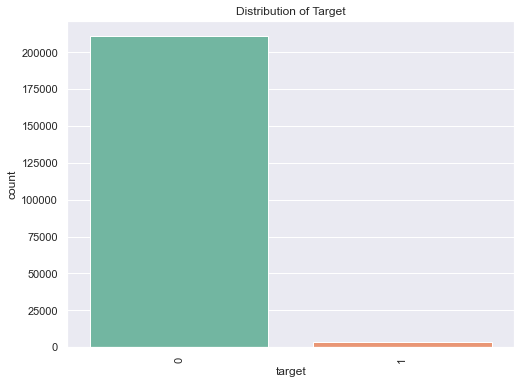

In [25]:
plt.figure(figsize=(8, 6))
sns.countplot(data_new['target'],palette='Set2')
plt.xticks(rotation=90)
plt.title('Distribution of Target')
plt.show()

### Only 3365 (or 1.57%) of applications are fraudulent. That means the data is highly unbalanced in favor of the non fraud class.


## Lets revisit the cleaned dataset again

In [26]:
# Lets get familiar with the dataset more
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214035 entries, 115225 to 134657
Data columns (total 62 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   monthnumber                                         214035 non-null  int64  
 1   applicationchannel                                  214035 non-null  object 
 2   credtiscore                                         214035 non-null  float64
 3   applicantage                                        214035 non-null  float64
 4   ea_fraudscore                                       214035 non-null  float64
 5   ea_lat                                              214035 non-null  float64
 6   ea_long                                             214035 non-null  float64
 7   ipreputation                                        214035 non-null  object 
 8   iprisklevel                                         214035 

In [27]:
data_new.describe().T

count         mean  \
monthnumber                                         214035.0     9.688850   
credtiscore                                         214035.0   736.463500   
applicantage                                        214035.0    41.544149   
ea_fraudscore                                       214035.0   325.133044   
ea_lat                                              214035.0    37.079154   
ea_long                                             214035.0   -94.077533   
ida95_idscore                                       214035.0   528.229886   
ida95_identitymatchconfidence                       214035.0     0.950920   
ida95_consistencysnapd                              214035.0    57.646738   
ida95_consistencyssndob                             214035.0    78.788968   
ida95_distancezipipaddr                             214035.0   255.267321   
ida95_distancezipprimphone                          214035.0   171.358861   
ida95_idscoreresultcode1                            214035.0   672.881394   
ida95_idscoreresultcode2                            214035.0   768.829750   
ida95_idscoreresultcode3                            214035.0   811.674009   
ida95_numaddrlinkssn3years                          214035.0     1.842104   
ida95_numaddrlinkprimphone3years                    214035.0     0.812079   
ida95_numdayslrmatchssnphone2years                  214035.0   221.804691   
ida95_numdayslrmatchssnphone3years                  214035.0   374.985474   
ida95_numdaysmrmatchssnphone3years                  214035.0   158.158125   
ida95_numnameslinkssn1year                          214035.0     0.241099   
ida95_numphoneslinkssn3years                        214035.0     1.453594   
ida95_numphoneslinkedtoaddr2years                   214035.0     3.952886   
ida95_numyearsbetweenssnissueyearanddob             214035.0   424.380236   
ida95_timesappliedbyaddr2years                      214035.0    12.032867   
ida95_timesappliedbyaddr6months                     214035.0     3.293198   
ida95_timesappliedbyprimphone2years                 214035.0     2.465993   
ida95_timesappliedbyssn2years                       214035.0     5.110382   
ida95_timesfraudreportedataddr2years                214035.0     0.027122   
ida95_primphonetypecode                             214035.0     3.875406   
ip_address_checks_distance_from_primary_address     214035.0   159.121682   
ip_address_checks_distance_from_primary_phone       214035.0   230.631334   
ip_address_checks_distance_from_secondary_address   214035.0   169.003235   
ip_address_checks_distance_from_secondary_phone     214035.0   225.222156   
primary_email_address_checks_email_first_seen_days  214035.0  1145.346079   
identity_check_score                                214035.0   281.998386   
businessverificationindex                           214035.0    29.603112   
comprehensiveverificationindex                      214035.0    39.078571   
timeonpublicrecord                                  214035.0    77.488042   
rulesetscore                                        214035.0    -0.238554   
devicetz                                            214035.0   357.482185   
target                                              214035.0     0.015722   
accountaddeddate_days                               214035.0   497.136067   
devicefirstseen_days                                214035.0    65.298792   
domainage_days                                      214035.0  5729.369715   
business_age                                        214035.0    36.330268   

                                                            std     min  \
monthnumber                                            1.608850    7.00   
credtiscore                                          165.112229    1.00   
applicantage                                          12.163732    0.00   
ea_fraudscore                                        258.746974    7.00   
ea_lat                                                 6.082

## Now let us know deep dive in some features and try to see if they are related to the target variable

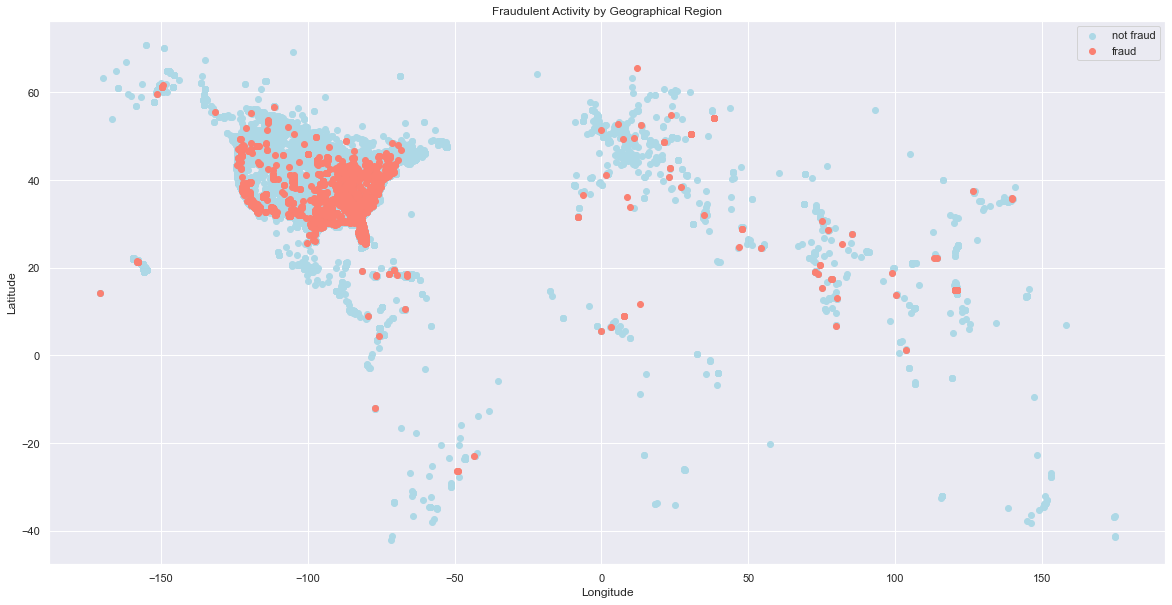

In [28]:
plt.figure(figsize=(20,10))

# Scatter Plot Negative Examples
plt.scatter(data_new.ea_long[data_new.target==0],
            data_new.ea_lat[data_new.target==0],
            c='lightblue')

# Scatter Plot Positive Examples
plt.scatter(data_new.ea_long[data_new.target==1],
            data_new.ea_lat[data_new.target==1],
            c='salmon')

plt.title("Fraudulent Activity by Geographical Region")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(['not fraud','fraud']);

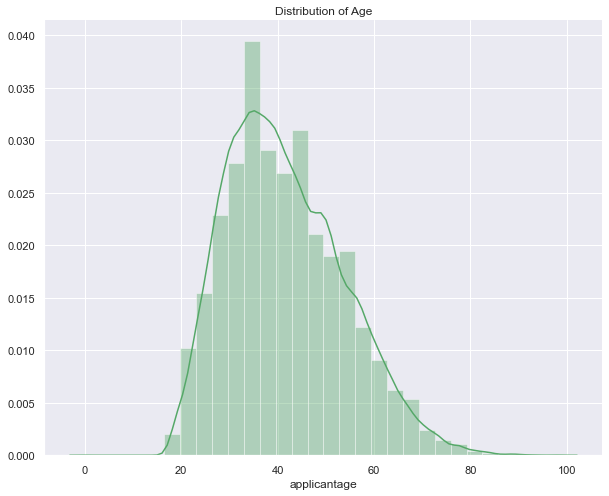

In [29]:
f, ax = plt.subplots(figsize=(10, 8))
sns.despine(f)
sns.distplot(data_new['applicantage'],bins=30,color="g")
plt.title('Distribution of Age')
plt.show()

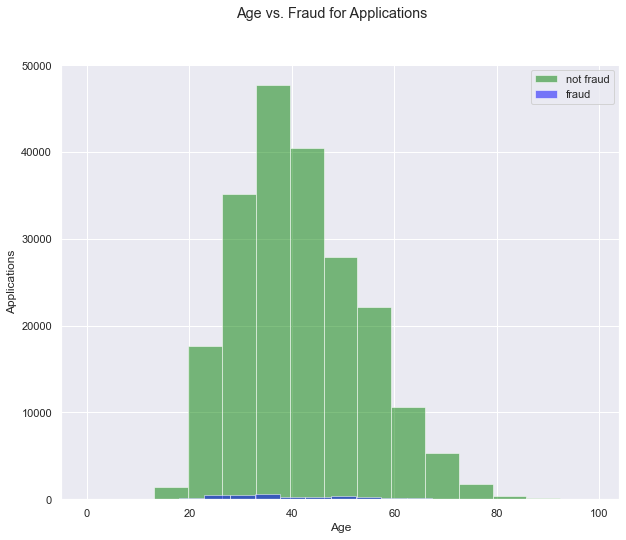

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(data_new[data_new["target"]==0]["applicantage"], bins=15, alpha=0.5, color="green", label="not fraud")
ax.hist(data_new[data_new["target"]==1]["applicantage"], bins=15, alpha=0.5, color="blue", label="fraud")

ax.set_xlabel("Age")
ax.set_ylabel("Applications")

fig.suptitle("Age vs. Fraud for Applications")

ax.legend();

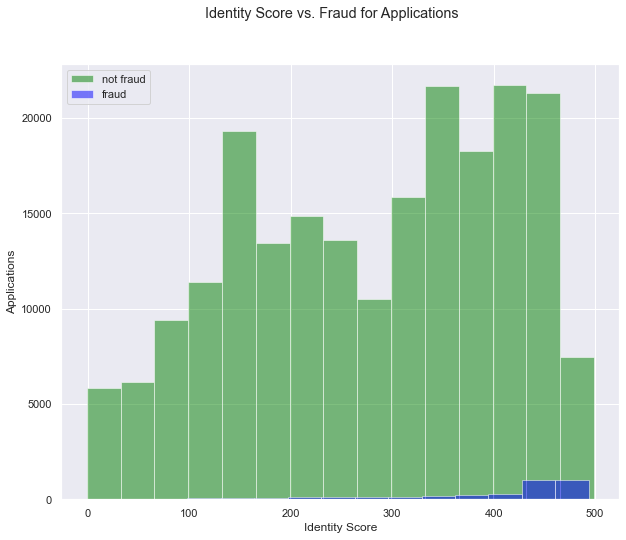

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(data_new[data_new["target"]==0]["identity_check_score"], bins=15, alpha=0.5, color="green", label="not fraud")
ax.hist(data_new[data_new["target"]==1]["identity_check_score"], bins=15, alpha=0.5, color="blue", label="fraud")

ax.set_xlabel("Identity Score")
ax.set_ylabel("Applications")

fig.suptitle("Identity Score vs. Fraud for Applications")

ax.legend();

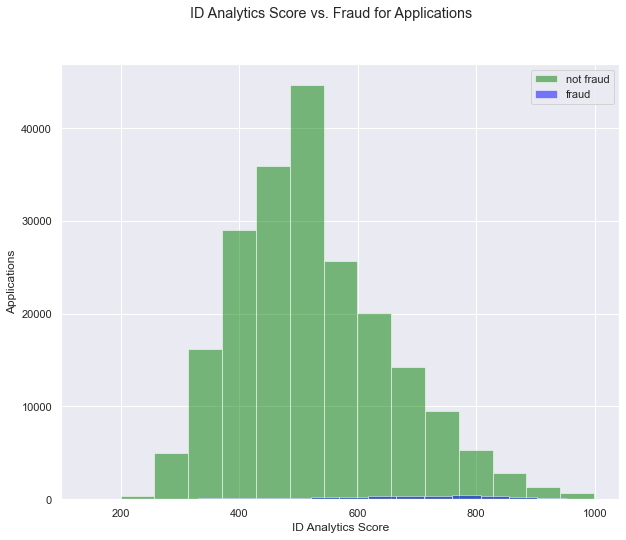

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(data_new[data_new["target"]==0]["ida95_idscore"], bins=15, alpha=0.5, color="green", label="not fraud")
ax.hist(data_new[data_new["target"]==1]["ida95_idscore"], bins=15, alpha=0.5, color="blue", label="fraud")

ax.set_xlabel("ID Analytics Score")
ax.set_ylabel("Applications")

fig.suptitle("ID Analytics Score vs. Fraud for Applications")

ax.legend();

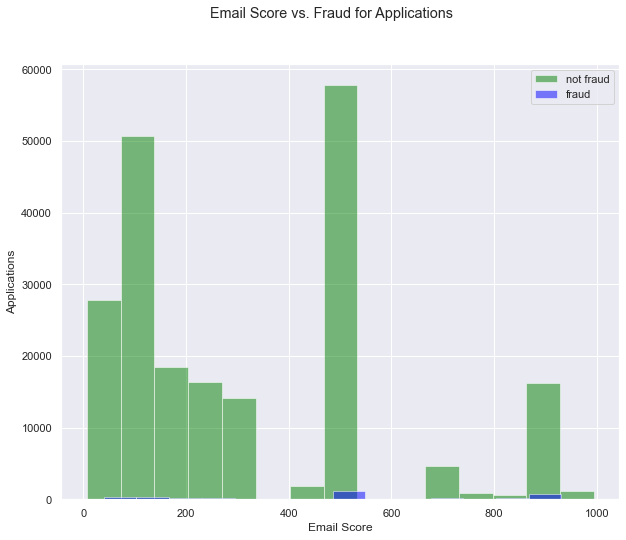

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(data_new[data_new["target"]==0]["ea_fraudscore"], bins=15, alpha=0.5, color="green", label="not fraud")
ax.hist(data_new[data_new["target"]==1]["ea_fraudscore"], bins=15, alpha=0.5, color="blue", label="fraud")

ax.set_xlabel("Email Score")
ax.set_ylabel("Applications")

fig.suptitle("Email Score vs. Fraud for Applications")

ax.legend();

## Using group by to evaluate a few catergories againt the target class

In [34]:
data_new.groupby(['primary_email_address_checks_is_disposable','target'])['target'].count()

primary_email_address_checks_is_disposable  target
False                                       0         210506
                                            1           3304
True                                        0            164
                                            1             61
Name: target, dtype: int64

In [35]:
data_new.groupby(['primary_email_address_checks_is_autogenerated','target'])['target'].count()

primary_email_address_checks_is_autogenerated  target
False                                          0         208821
                                               1           3288
True                                           0           1849
                                               1             77
Name: target, dtype: int64

In [36]:
# For the remaining charts, lets create two datasets split on the target class
fraud = data_new[data_new['target'] == 1]
notfraud = data_new[data_new['target'] == 0]

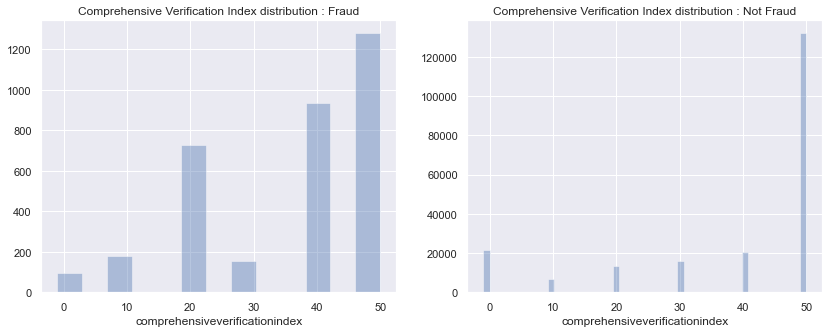

In [37]:
plt.figure(figsize = (14, 5))

plt.subplot(1, 2, 1)
sns.distplot(fraud['comprehensiveverificationindex'], kde = False)
plt.title('Comprehensive Verification Index distribution : Fraud')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.distplot(notfraud['comprehensiveverificationindex'], kde = False)
plt.title('Comprehensive Verification Index distribution : Not Fraud')
plt.grid(True)

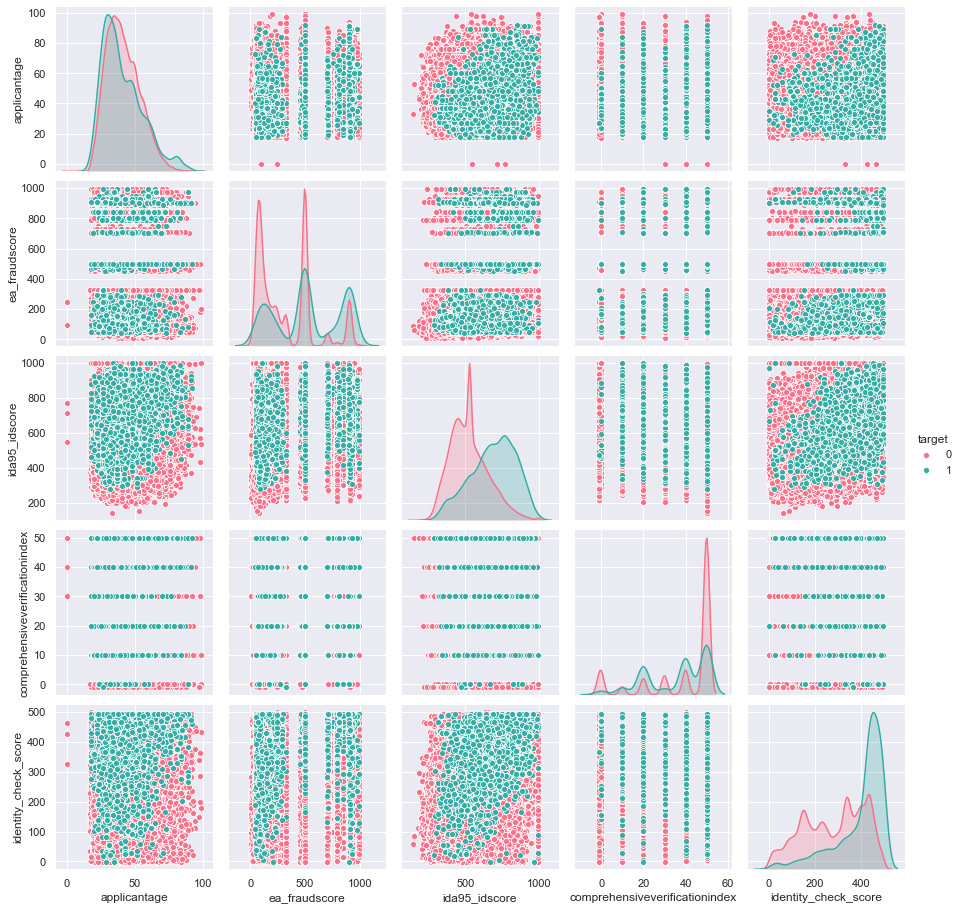

In [38]:
sns.pairplot(data_new,vars = ['applicantage',
                              'ea_fraudscore',
                              "ida95_idscore",
                              "comprehensiveverificationindex",
                              "identity_check_score"],
                         hue ='target',diag_kind = "kde",kind = "scatter", palette = "husl")

## Corelation Matrix


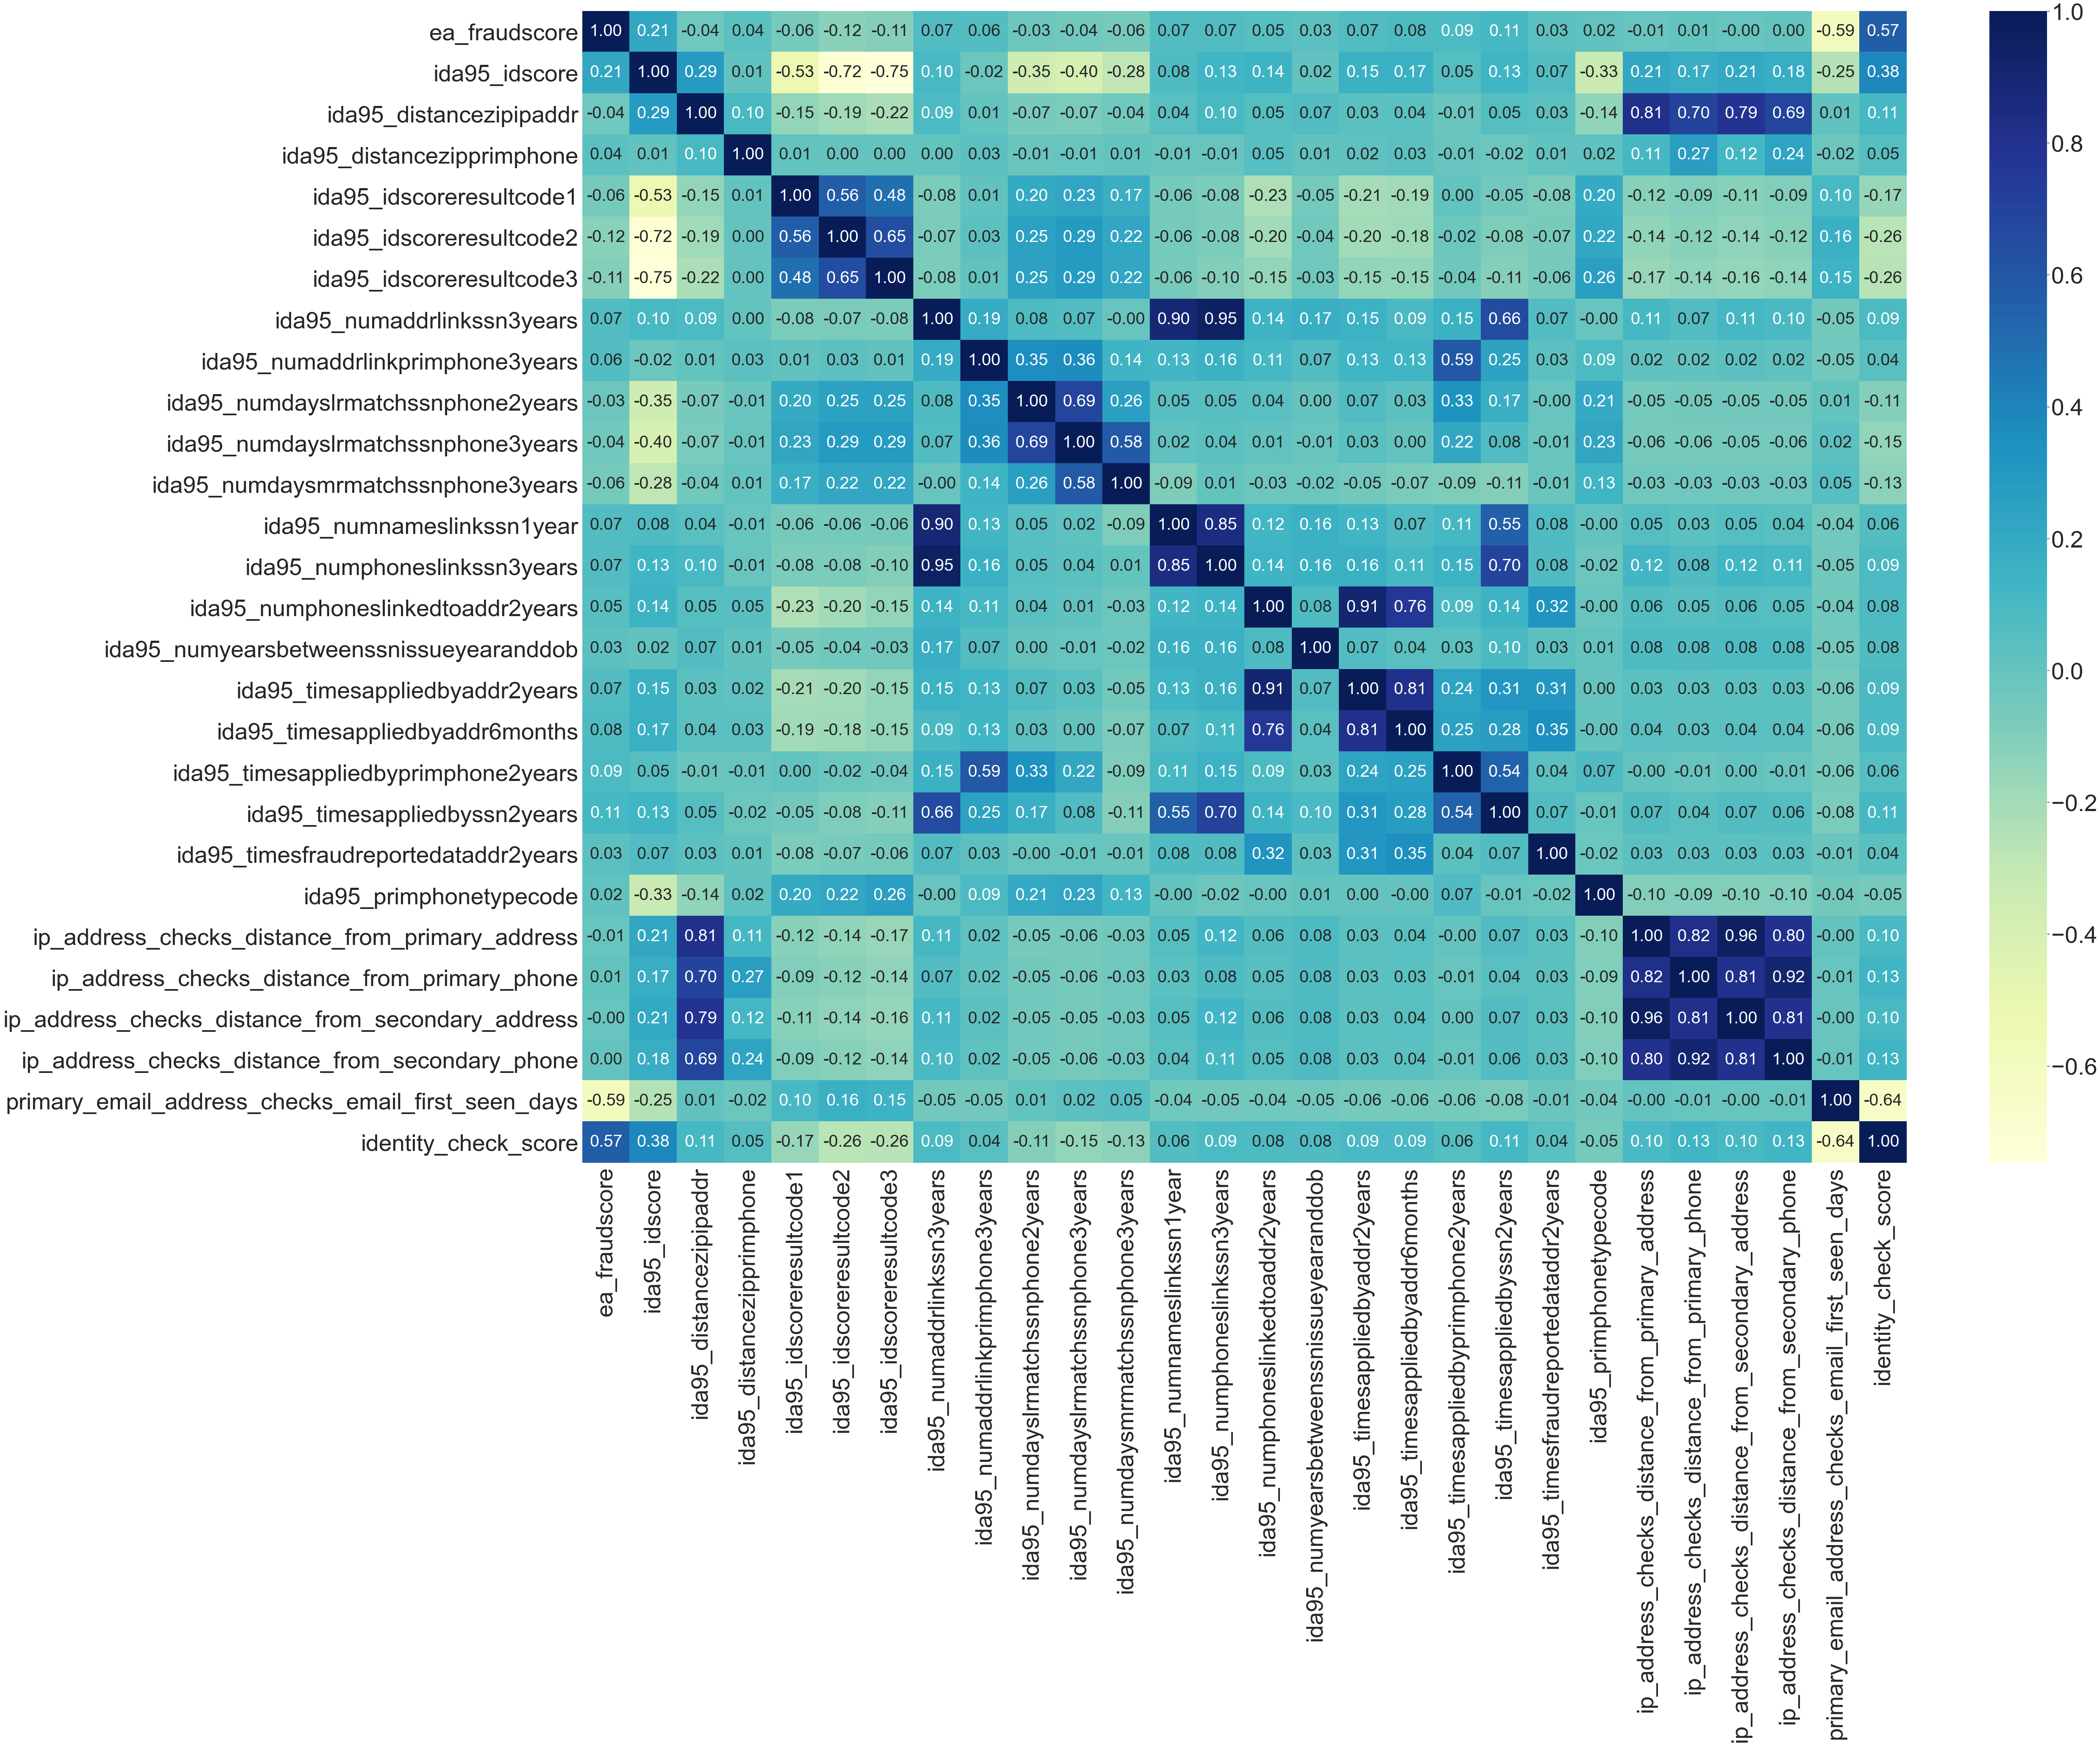

In [39]:
sns.set(font_scale=5)

fig, ax = plt.subplots(figsize=(70,50))
ax = sns.heatmap(data_new[['ea_fraudscore', 'ida95_idscore',  'ida95_distancezipipaddr',
       'ida95_distancezipprimphone', 'ida95_idscoreresultcode1',
       'ida95_idscoreresultcode2', 'ida95_idscoreresultcode3',
       'ida95_numaddrlinkssn3years',
       'ida95_numaddrlinkprimphone3years',
       'ida95_numdayslrmatchssnphone2years',
       'ida95_numdayslrmatchssnphone3years',
       'ida95_numdaysmrmatchssnphone3years', 'ida95_numnameslinkssn1year',
       'ida95_numphoneslinkssn3years', 'ida95_numphoneslinkedtoaddr2years',
       'ida95_numyearsbetweenssnissueyearanddob',
       'ida95_timesappliedbyaddr2years', 'ida95_timesappliedbyaddr6months',
       'ida95_timesappliedbyprimphone2years', 'ida95_timesappliedbyssn2years',
       'ida95_timesfraudreportedataddr2years', 'ida95_primphonetypecode',
       'ip_address_checks_distance_from_primary_address',
       'ip_address_checks_distance_from_primary_phone',
       'ip_address_checks_distance_from_secondary_address',
       'ip_address_checks_distance_from_secondary_phone',
       'primary_email_address_checks_email_first_seen_days', 'identity_check_score']].corr(),
                 annot=True,
                 fmt='.2f',
                 annot_kws={'size': 40},
                 cmap='YlGnBu');

### Correlation matrices provide valuable insights about the relationships between the features. We want to know if there are features that influence heavily in whether a specific application is a fraud and it is important for us to see which features have a high positive or negative correlation with regards to the target variable.


From the above matrix - 

1. High positive coorelation between the ip address distance features from various vendors. This is understandble and therefore we can remove some of these from the dataset.
    
    ida95_distancezipipaddr
    ip_address_checks_distance_from_primary_address
    ip_address_checks_distance_from_primary_phone
    ip_address_checks_distance_from_secondary_address
    ip_address_checks_distance_from_secondary_phone
    
    
2. Similar relation exists between names, phone and addrress links with a SSN. Again this helps us elimiate features which are not adding value


We are going to drop the following features from the dataset.

    ip_address_checks_distance_from_primary_address
    ip_address_checks_distance_from_primary_phone
    ip_address_checks_distance_from_secondary_address
    ip_address_checks_distance_from_secondary_phone
    ida95_numnameslinkssn1year
    ida95_numphoneslinkssn3years
    ida95_timesappliedbyaddr2years



In [40]:
# Make a copy of the dataset
data_final=data_new

In [41]:
# Revert scale back to normal (for ROC charts later)
sns.set(font_scale=1)

## Next we will scale the continuous features using Standard Scaler

<a id='step_5'></a>
# Step 5 : Standard Scaler


[Return to the top](#step_0)

In [42]:
# Turn Categories into numbers
continuous_features = ['credtiscore',
'applicantage',
'ea_fraudscore',
'ea_lat',
'ea_long',
'ida95_idscore',
'ida95_identitymatchconfidence',
'ida95_consistencysnapd',
'ida95_consistencyssndob',
'ida95_distancezipipaddr',
'ida95_distancezipprimphone',
'ida95_idscoreresultcode1',
'ida95_idscoreresultcode2',
'ida95_idscoreresultcode3',
'ida95_numaddrlinkssn3years',
'ida95_numaddrlinkprimphone3years',
'ida95_numdayslrmatchssnphone2years',
'ida95_numdayslrmatchssnphone3years',
'ida95_numdaysmrmatchssnphone3years',
'ida95_numnameslinkssn1year',
'ida95_numphoneslinkssn3years',
'ida95_numphoneslinkedtoaddr2years',
'ida95_numyearsbetweenssnissueyearanddob',
'ida95_timesappliedbyaddr2years',
'ida95_timesappliedbyaddr6months',
'ida95_timesappliedbyprimphone2years',
'ida95_timesappliedbyssn2years',
'ida95_timesfraudreportedataddr2years',
'ida95_primphonetypecode',
'ip_address_checks_distance_from_primary_address',
'ip_address_checks_distance_from_primary_phone',
'ip_address_checks_distance_from_secondary_address',
'ip_address_checks_distance_from_secondary_phone',
'primary_email_address_checks_email_first_seen_days',
'identity_check_score',
'businessverificationindex',
'comprehensiveverificationindex',
'timeonpublicrecord',
'rulesetscore',
'devicetz',
'accountaddeddate_days',
'devicefirstseen_days',
'domainage_days',
'business_age',]

In [43]:
data_final.shape

(214035, 62)

In [44]:
standard_scaler = StandardScaler()
transformer = ColumnTransformer([("standard scaler",
                                   standard_scaler,
                                   continuous_features)],
                                remainder='passthrough')


scaled_data = transformer.fit_transform(data_final)
scaled_data = pd.DataFrame(scaled_data)

In [45]:
scaled_data.head()

0         1         2         3         4         5         6   \
0  0.705803 -0.866854  2.237198  0.264848  0.843907  0.081836  0.279591   
1 -0.735644 -0.044735 -0.738689 -1.158991 -0.069105 -0.966753  0.299523   
2  0.372696  0.119688  1.468105 -0.289232  0.634566  1.289994 -0.869858   
3 -0.560005 -0.126947  1.483565  0.772893  0.302951  1.084835  -0.47785   
4 -0.820435 -0.538006 -0.510666 -0.142903   0.36956 -0.586829 -6.318114   

         7         8         9         10        11        12        13  \
0   0.20857  0.361095 -0.348169 -0.301162 -1.779096 -0.489376  0.992792   
1  0.892759  0.361095 -0.358188 -0.343435  1.151885   1.01271  0.601898   
2 -2.217193 -2.836478  0.106959 -0.376809 -0.165613 -0.489376 -0.499209   
3 -1.533003  0.361095 -0.365344 -0.352335 -1.876555 -0.917054 -1.198413   
4 -2.714785 -4.348057 -0.363912 -0.316736  1.151885  0.861458  0.833131   

         14        15        16        17        18        19        20  \
0 -0.639028 -1.004658 -0.878226 -0.967783 -0.646024 -0.426639 -0.643334   
1 -0.140061  0.424403  1.433053  1.383738  -0.59762  0.144472 -0.084495   
2 -0.639028 -1.004658 -0.878226 -0.967783 -0.646024 -0.426639 -0.643334   
3  0.192584  0.067138 -0.874302 -0.965216  -0.64199  0.334842  0.101784   
4  0.192584  0.424403  1.452673  0.557112  1.749971  0.144472  0.101784   

         21        22        23        24        25        26        27  \
0 -0.277633 -0.219096 -0.186153 -0.099871 -0.575523 -0.556689 -0.099411   
1  0.098451 -0.218579  0.146735 -0.099871  0.842023  -0.24352 -0.099411   
2 -0.277633 -0.216514 -0.334104 -0.022643 -0.575523 -0.556689 -0.099411   
3 -0.277633 -0.218063 -0.112178   0.20904 -0.188919   1.00916 -0.099411   
4 -0.089591 -0.213417  0.257697 -0.177099  0.970891 -0.008642 -0.099411   

         28        29        30        31        32        33        34  \
0  0.375599 -0.243278 -0.331507 -0.257594 -0.329134  -0.81484  0.337766   
1  0.375599 -0.254932 -0.326938 -0.269152 -0.324481   0.05738 -1.374032   
2  0.375599  0.287825   0.08891  0.265839  0.162499 -0.715239   0.73693   
3  0.375599 -0.261592 -0.348263 -0.275757   0.00283  -0.81484  1.097713   
4  0.375599 -0.256597 -0.311705 -0.270804 -0.308972 -0.333909 -0.330065   

         35        36        37        38        39        40        41  \
0 -1.409389  0.641026 -0.523348  0.066394 -0.697161 -0.413696  -0.34672   
1  0.494991  0.641026 -0.510012  0.066394  0.030537  -0.44355 -0.331031   
2  0.971086  0.641026  1.977102 -0.000959 -0.000228 -0.485698 -0.634352   
3  0.494991  0.054083 -0.476673  0.066394  0.030537 -0.433013 -0.341491   
4  0.971086 -1.119804 -0.283305  0.066394  0.030537 -0.344327  -0.34672   

         42        43  44        45    46        47     48     49        50  \
0 -1.397453 -0.149012  10    QBO_V3  Good  Moderate   True  False     Match   
1  0.892287 -0.149012   9   QBO_SPA  Good  Moderate   True  False     Match   
2 -1.315949 -0.021863   7  QBDT_SPA  Good  Very Low  False  False     Match   
3 -1.367748 -0.149012   7   QBO_SPA  Good  Moderate  False  False  No match   
4 -1.211858 -0.140809  12    QBO_V3  Good  Moderate   True  False     Match   

      51     52      53                54     55    56        57  \
0  False  False  Mobile            Sprint     NA    NA        NA   
1  False  False  Mobile                NA  _3333    NA      Pass   
2  False  False  Mobile                NA   ND00    NA    NoData   
3  False  False  Mobile                NA  _1111  CA01  Declined   
4  False  False  Mobile  Verizon Wireless     NA    NA        NA   

                    58                       59      60 61  
0                   10          WINDOWS NT 10.0    EDGE  0  
1                   10  CROS X86_64 13099.110.0  CHROME  0  
2           [27,10,82]                       NA      NA  0  
3  [PA,27,74,VA,10,82]          WINDOWS NT 10.0  CHROME  0  
4  [51,72,26,27,74,52]   INTEL MAC OS X 10_15_6  SAFARI  0

In [46]:
# Add columns names after scaling
scaled_data.columns = ['credtiscore',
'applicantage',
'ea_fraudscore',
'ea_lat',
'ea_long',
'ida95_idscore',
'ida95_identitymatchconfidence',
'ida95_consistencysnapd',
'ida95_consistencyssndob',
'ida95_distancezipipaddr',
'ida95_distancezipprimphone',
'ida95_idscoreresultcode1',
'ida95_idscoreresultcode2',
'ida95_idscoreresultcode3',
'ida95_numaddrlinkssn3years',
'ida95_numaddrlinkprimphone3years',
'ida95_numdayslrmatchssnphone2years',
'ida95_numdayslrmatchssnphone3years',
'ida95_numdaysmrmatchssnphone3years',
'ida95_numnameslinkssn1year',
'ida95_numphoneslinkssn3years',
'ida95_numphoneslinkedtoaddr2years',
'ida95_numyearsbetweenssnissueyearanddob',
'ida95_timesappliedbyaddr2years',
'ida95_timesappliedbyaddr6months',
'ida95_timesappliedbyprimphone2years',
'ida95_timesappliedbyssn2years',
'ida95_timesfraudreportedataddr2years',
'ida95_primphonetypecode',
'ip_address_checks_distance_from_primary_address',
'ip_address_checks_distance_from_primary_phone',
'ip_address_checks_distance_from_secondary_address',
'ip_address_checks_distance_from_secondary_phone',
'primary_email_address_checks_email_first_seen_days',
'identity_check_score',
'businessverificationindex',
'comprehensiveverificationindex',
'timeonpublicrecord',
'rulesetscore',
'devicetz',
'accountaddeddate_days',
'devicefirstseen_days',
'domainage_days',
'business_age',
'monthnumber',
'applicationchannel',
'ipreputation',
'iprisklevel',
'ida95_namessndob6primphoneconfirmed',
'ida95_primphonemismatchwithzip',
'primary_address_checks_match_to_name',
'primary_email_address_checks_is_autogenerated',
'primary_email_address_checks_is_disposable',
'primary_phone_checks_line_type',
'primary_phone_checks_carrier',
'accountresponsecode',
'customerresponsecode',
'verificationresponse',
'comprehensiveriskindicators',
'deviceos',
'devicebrowsertype',
'target']

In [47]:
scaled_data.head()

credtiscore applicantage ea_fraudscore    ea_lat   ea_long ida95_idscore  \
0    0.705803    -0.866854      2.237198  0.264848  0.843907      0.081836   
1   -0.735644    -0.044735     -0.738689 -1.158991 -0.069105     -0.966753   
2    0.372696     0.119688      1.468105 -0.289232  0.634566      1.289994   
3   -0.560005    -0.126947      1.483565  0.772893  0.302951      1.084835   
4   -0.820435    -0.538006     -0.510666 -0.142903   0.36956     -0.586829   

  ida95_identitymatchconfidence ida95_consistencysnapd  \
0                      0.279591                0.20857   
1                      0.299523               0.892759   
2                     -0.869858              -2.217193   
3                      -0.47785              -1.533003   
4                     -6.318114              -2.714785   

  ida95_consistencyssndob ida95_distancezipipaddr ida95_distancezipprimphone  \
0                0.361095               -0.348169                  -0.301162   
1                0.361095               -0.358188                  -0.343435   
2               -2.836478                0.106959                  -0.376809   
3                0.361095               -0.365344                  -0.352335   
4               -4.348057               -0.363912                  -0.316736   

  ida95_idscoreresultcode1 ida95_idscoreresultcode2 ida95_idscoreresultcode3  \
0                -1.779096                -0.489376                 0.992792   
1                 1.151885                  1.01271                 0.601898   
2                -0.165613                -0.489376                -0.499209   
3                -1.876555                -0.917054                -1.198413   
4                 1.151885                 0.861458                 0.833131   

  ida95_numaddrlinkssn3years ida95_numaddrlinkprimphone3years  \
0                  -0.639028                        -1.004658   
1                  -0.140061                         0.424403   
2                  -0.639028                        -1.004658   
3                   0.192584                         0.067138   
4                   0.192584                         0.424403   

  ida95_numdayslrmatchssnphone2years ida95_numdayslrmatchssnphone3years  \
0                          -0.878226                          -0.967783   
1                           1.433053                           1.383738   
2                          -0.878226                          -0.967783   
3                          -0.874302                          -0.965216   
4                           1.452673                           0.557112   

  ida95_numdaysmrmatchssnphone3years ida95_numnameslinkssn1year  \
0                          -0.646024                  -0.426639   
1                           -0.59762                   0.144472   
2                          -0.646024                  -0.426639   
3                           -0.64199                   0.334842   
4                           1.749971                   0.144472   

  ida95_numphoneslinkssn3years ida95_numphoneslinkedtoaddr2years  \
0                    -0.643334                         -0.277633   
1                    -0.084495                          0.098451   
2                    -0.643334                         -0.277633   
3                     0.101784                         -0.277633   
4                     0.101784                         -0.089591   

  ida95_numyearsbetweenssnissueyearanddob ida95_timesappliedbyaddr2years  \
0                               -0.219096                      -0.186153   
1                               -0.218579                       0.146735   
2                               -0.216514                      -0.334104   
3                               -0.218063                      -0.112178   
4                               -0.213417                       0.257697   

  ida95_timesappliedbyaddr6months ida95_timesappliedbyprimphone2years  \
0                       -0.099871     

In [48]:
scaled_data.drop(['ip_address_checks_distance_from_primary_address',
'ip_address_checks_distance_from_primary_phone',
'ip_address_checks_distance_from_secondary_address',
'ip_address_checks_distance_from_secondary_phone',
'ida95_numnameslinkssn1year',
'ida95_numphoneslinkssn3years',
'ida95_timesappliedbyaddr2years',
'deviceos',
'devicebrowsertype',
'comprehensiveriskindicators',
'primary_phone_checks_carrier'],axis=1,inplace=True)

### Now that we have our features setup, 15 of them are categories and next we will use One Hot Encoder to convert them into numerical categories, so that the model can consume them. 

<a id='step_6'></a>
# Step 6 : One Hot Encoding


[Return to the top](#step_0)

In [49]:
# Turn Categories into numbers
categorical_features = ['applicationchannel','ipreputation','iprisklevel','ida95_namessndob6primphoneconfirmed',
                       'ida95_primphonemismatchwithzip','primary_address_checks_match_to_name','primary_email_address_checks_is_autogenerated',
                       'primary_email_address_checks_is_disposable','primary_phone_checks_line_type',
                       'accountresponsecode','customerresponsecode','verificationresponse']

In [50]:
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one hot",
                                   one_hot,
                                   categorical_features)],
                                remainder='passthrough')


transformed_data = transformer.fit_transform(scaled_data)
transformed_data = pd.DataFrame(transformed_data)

In [51]:
# Convert all columns to numeric
df = transformed_data.apply(pd.to_numeric)

In [52]:
df.head()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   

   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   \
0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0   
3  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0   
4  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   

   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   \
0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
2  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
4  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   

   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   \
0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0   
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   \
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   

   75   76        77        78        79        80        81        82   \
0  0.0  0.0  0.705803 -0.866854  2.237198  0.264848  0.843907  0.081836   
1  0.0  0.0 -0.735644 -0.044735 -0.738689 -1.158991 -0.069105 -0.966753   
2  0.0  0.0  0.372696  0.119688  1.468105 -0.289232  0.634566  1.289994   
3  0.0  0.0 -0.560005 -0.126947  1.483565  0.772893  0.302951  1.084835   
4  0.0  0.0 -0.820435 -0.538006 -0.510666 -0.142903  0.369560 -0.586829   

        83        84        85        86        87        88        89   \
0  0.279591  0.208570  0.361095 -0.348169 -0.301162 -1.779096 -0.489376   
1  0.299523  0.892759  0.361095 -0.358188 -0.343435  1.151885  1.012710   
2 -0.869858 -2.217193 -2.836478  0.106959 -0.376809 -0.165613 -0.489376   
3 -0.477850 -1.533003  0.361095 -0.365344 -0.352335 -1.876555 -0.917054   
4 -6.318114 -2.714785 -4.348057 -0.363912 -0.316736  1.151885  0.861458   

        90        91        92        93        94        95        96   \
0  0.992792 -0.639028 -1.004658 -0.878226 -0.967783 -0.646024 -0.277633   
1  0.601898 -0.140061  0.424403  1.433053  1.383738 -0.597620  0.098451   
2 -0.499209 -0.639028 -1.004658 -0.878226 -0.967783 -0.646024 -0.277633   
3 -1.198413  0.192584  0.067138 -0.874302 -0.965216 -0.641990 -0.277633   
4  0.833131  0.192584  0.424403  1.452673  0.557112  1.749971 -0.089591   

        97        98        99        100       101       102       103  \
0 -0.219096 -0.099871 -0.575523 -0.556689 -0.099411  0.375599 -0.814840   
1 -0.218579 -0.099871  0.842023 -0.243520 -0.099411  0.375599  0.057380   
2 -0.216514 -0.02264

In [53]:
df.shape

(214035, 116)

## Now our dataset is ready for Modeling


<a id='step_7'></a>
# Step 7 : Model Selection


[Return to the top](#step_0)

In [91]:
# Splitting in features and label

X = df.drop([115],axis=1)
y = df[115]

np.random.seed(25)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [92]:
X_train.head()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   \
57025   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
43425   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
147720  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
78314   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
160907  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   

        14   15   16   17   18   19   20   21   22   23   24   25   26   27   \
57025   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
43425   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
147720  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   
78314   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
160907  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

        28   29   30   31   32   33   34   35   36   37   38   39   40   41   \
57025   1.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   
43425   1.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   
147720  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   
78314   1.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   
160907  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   

        42   43   44   45   46   47   48   49   50   51   52   53   54   55   \
57025   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
43425   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
147720  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
78314   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
160907  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

        56   57   58   59   60   61   62   63   64   65   66   67   68   69   \
57025   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
43425   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
147720  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
78314   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
160907  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

        70   71   72   73   74   75   76        77        78        79   \
57025   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.172831 -0.784642  2.237198   
43425   1.0  0.0  0.0  0.0  0.0  0.0  0.0 -0.075485 -0.455795  2.237198   
147720  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.002661 -0.538006 -0.893280   
78314   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.063814 -0.949065 -0.993765   
160907  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.281171  0.119688  2.237198   

             80        81        82        83        84        85        86   \
57025  -0.716713 -0.142850 -1.179511  0.279591  0.021973  0.361095 -0.359619   
43425   1.391095 -1.367970 -0.807185  0.279591  0.395167  0.361095 -0.361050   
147720 -0.234975  0.743043  0.165420  0.053687 -2.776984 -4.580608 -0.212203   
78314   1.274360  1.223099 -1.605025  0.319456  0.457366  0.361095 -0.365344   
160907  0.478589  0.527041 -1.339079  0.319456  1.141555  0.361095 -0.365344   

             87        88        89        90        91        92        93   \
57025  -0.370134  1.151885  1.012710  1.003803 -0.639028 -1.004658 -0.878226   
43425  -0.363459  1.151885  0.924045  0.833131 -0.140061  0.067138  0.895455   
147720 -0.363459 -1.587788 -0.739724 -3.158384 -0.140061  0.067138 -0.874302   
78314  -0.379034  1.151885  0.861458  0.535832 -0.140061  0.067138  1.491914   
160907 -0.009698  1.151885  1.012710  1.003803 -0.140061  0.067138 -0.878226   

             94        95        96        97        98        99        100  \
57025  -0.967783 -0.646024 -0.559695 -0.218579 -0.408782 -0.575523 -0.556689   
43425   0.192574  1.177191 -0.

In [93]:
pd.DataFrame(y_train).value_counts()

115
0      168531
1        2697
dtype: int64

### In the initial runs for the model I was getting poor scores, so I tried to run a PCA in order to reduce dimentions of my data. However, it did not help with increasing the model scores or precision (due to the data being imbalanced) so I dropped the idea. 


In [57]:
#from sklearn.decomposition import PCA
# Make an instance of the Model
#pca = PCA(.95)

#pca.fit(X_train)

#pca.n_components_


#X_train = pca.transform(X_train)
#X_test = pca.transform(X_test)

#pd.DataFrame(X_train).head()

### Stated with KNN model but it was very slow and did not give good AUC so dropped it. 


![title](img/knn.png)


## Starting with model selection




In [67]:
models = {"Logistic Regression" : LogisticRegression(max_iter=1000),
          "Linear SVC" : LinearSVC(max_iter=1000),
          "Random Forest Classifier" : RandomForestClassifier(),
          "Decision Tree Classifier" : DecisionTreeClassifier(),
          "Gradient Boosting Classifier" : GradientBoostingClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluated given ML models
    models : a dict of different Scikit-Learn models
    """
    
    # Make a dict to score model scores
    model_scores = {}
    
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
        plot_roc_curve(model, X_test,y_test)
    return model_scores

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


CPU times: user 7min 32s, sys: 20.4 s, total: 7min 52s
Wall time: 3min 19s


{'Logistic Regression': 0.9833905669633471,
 'Linear SVC': 0.9836708949470881,
 'Random Forest Classifier': 0.9899549139159484,
 'Decision Tree Classifier': 0.9792557292031677,
 'Gradient Boosting Classifier': 0.9863807321232508}

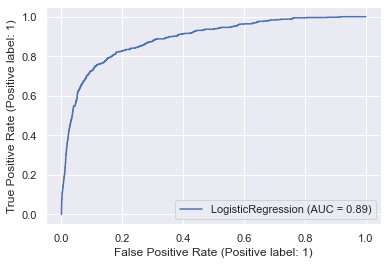

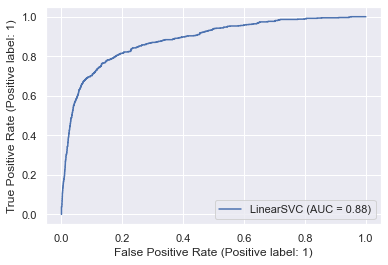

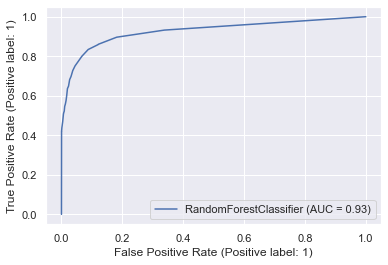

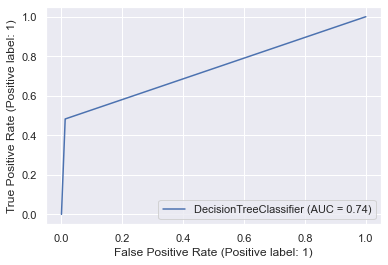

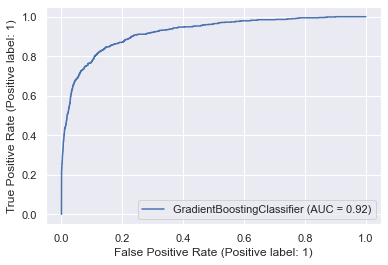

In [68]:
%%time
fit_and_score(models, X_train, X_test, y_train, y_test)

In [69]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     42084
           1       0.99      0.42      0.59       723

    accuracy                           0.99     42807
   macro avg       0.99      0.71      0.79     42807
weighted avg       0.99      0.99      0.99     42807



<a id='step_8'></a>
# Step 8 : Model Tuning and Cross Validation

From the above AUC values and scores, the Randon Forest Clasifier has the best perfomance. So we will select it for futher tuning using Randomozed Search CV. 

Below is an image of the tuning code since it takes a lot of processing time. 


[Return to the top](#step_0)




![title](img/tuning.png)

In [94]:
model = RandomForestClassifier(n_estimators=760,
                               min_samples_split=2,
                              min_samples_leaf=5,
                              max_depth=None)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9885532739972435

<a id='step_9'></a>
# Step 9 : Model Validation

[Return to the top](#step_0)

### Validating our tuned ML Model:

* ROC and AUC
* Confusion Matrix
* Classification Report
* Precision, Recall and F1 Score

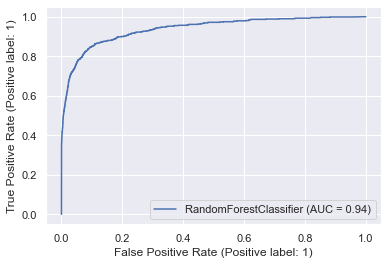

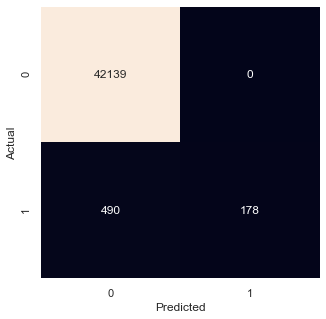

In [95]:
# Plot ROC Curve and calculate AUC metric
plot_roc_curve(model, X_test,y_test)

# Confusion Matrix
def plot_conf_matrix(y_test, y_preds):
    fig,ax = plt.subplots(figsize=(5,5))
    
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False,
                     fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plot_conf_matrix(y_test, model.predict(X_test))

In [96]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     42139
           1       1.00      0.27      0.42       668

    accuracy                           0.99     42807
   macro avg       0.99      0.63      0.71     42807
weighted avg       0.99      0.99      0.99     42807



<a id='step_10'></a>
# Step 10 : Next Steps


[Return to the top](#step_0)


## 1. Adjusting probability threshold to fine tune precision and recall

In [97]:
model.predict_proba(X_test)[70:75]

array([[0.9974292 , 0.0025708 ],
       [0.00955652, 0.99044348],
       [0.99709255, 0.00290745],
       [0.9962151 , 0.0037849 ],
       [1.        , 0.        ]])

In [98]:
model.predict(X_test)[70:75]

array([0, 1, 0, 0, 0])

In [99]:
model.predict_proba(X_test)[:,1] >= 0.04

array([False, False, False, ..., False, False, False])

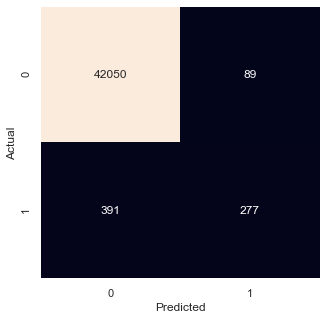

In [100]:
plot_conf_matrix(y_test, (model.predict_proba(X_test)[:,1] >= 0.2).astype(int))

In [101]:
print(classification_report(y_test, (model.predict_proba(X_test)[:,1] >= 0.2).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     42139
           1       0.76      0.41      0.54       668

    accuracy                           0.99     42807
   macro avg       0.87      0.71      0.77     42807
weighted avg       0.99      0.99      0.99     42807



## 2. Undersampling and Oversampling

![title](img/sampling.png)

## Undersampling

In [78]:
testing = df.sample(frac=1)

In [79]:
testing[115].value_counts()

0    210670
1      3365
Name: 115, dtype: int64

In [80]:
fraud_df = testing.loc[testing[115] == 1]
non_fraud_df = testing.loc[testing[115] == 0][:3365]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=9)
#new_df.head()

In [81]:
new_df[115].value_counts()

0    3365
1    3365
Name: 115, dtype: int64

In [82]:
# Splitting in features and label

X = new_df.drop([115],axis=1)
y = new_df[115]

np.random.seed(25)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [84]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8759286775631501

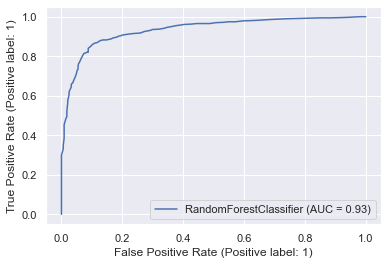

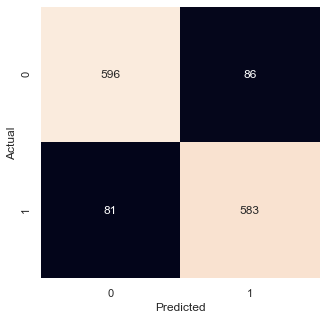

In [85]:
# Plot ROC Curve and calculate AUC metric
plot_roc_curve(model, X_test,y_test)

# Confusion Matrix
def plot_conf_matrix(y_test, y_preds):
    fig,ax = plt.subplots(figsize=(5,5))
    
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False,
                     fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plot_conf_matrix(y_test, model.predict(X_test))

In [86]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       682
           1       0.87      0.88      0.87       664

    accuracy                           0.88      1346
   macro avg       0.88      0.88      0.88      1346
weighted avg       0.88      0.88      0.88      1346



## Conclusion


![title](img/final.png)

## Other ways to make the model better?

1. More rows and columns (bigger slice and more features)
2. More Vendors and larger ecosystem data (scope)
3. Oversampling and Synthetic Data
4. Modern ML Techniques (Neural Networks/Deep Learning)
